In [1]:
import numpy as np 
import math
import pandas as pd
import random as rd
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.base import clone
from mlxtend.classifier import StackingClassifier
from keras_tuner.tuners import RandomSearch
import numpy as np

In [2]:
exps_dir = "../../exps"
if os.path.exists(exps_dir) == False: # tạo thư mục (nếu chưa có)
  os.makedirs(exps_dir, exist_ok=True)

save_dir = f"{exps_dir}/feature1"
os.makedirs(save_dir, exist_ok=True)
test_size=0.33
seed=42

In [3]:
x_train=pd.read_excel(f'{save_dir}/x_train.xlsx')
y_train=pd.read_excel(f'{save_dir}/y_train.xlsx')
x_test=pd.read_excel(f'{save_dir}/x_test.xlsx')
y_test=pd.read_excel(f'{save_dir}/y_test.xlsx')
x_train

,months_as_customer,age,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_sex,insured_education_level,insured_occupation,...,auto_year,day_policy_bind_date,month_policy_bind_date,year_policy_bind_date,day_incident_date,month_incident_date,year_incident_date,week_incident_date,high_week,high_hour
0,2,0,0,1,1,-1.770734,0,1,2,11,...,2,0.579574,-0.179439,-1.020460,-1.393943,-0.947412,0,-1.705084,0,0
1,0,2,1,0,2,-1.979562,0,1,4,11,...,0,-0.547936,-0.179439,0.908584,0.115223,0.953085,0,1.136723,0,0
2,2,0,2,0,2,0.675544,0,0,0,5,...,1,1.481582,0.108179,-0.744883,0.115223,-0.947412,0,-0.893139,1,0
3,2,0,0,0,2,-0.492901,0,0,2,2,...,0,1.368831,-0.467057,1.735317,-1.626123,2.853582,0,1.542695,0,0
4,2,0,2,1,1,0.613672,0,1,4,2,...,1,0.128570,0.971032,1.735317,1.160031,-0.947412,0,-0.487167,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017,2,0,2,0,2,-1.393488,0,0,0,6,...,1,0.908354,0.656524,0.393463,-0.917630,-0.947412,0,-1.409131,0,0
1018,1,0,0,0,0,0.661055,0,0,1,3,...,0,0.839585,-0.592273,1.479683,0.680663,0.953085,0,1.071228,0,0
1019,0,0,1,0,1,-0.077354,5,1,4,3,...,1,-0.883912,-0.196871,-1.006542,-0.093503,0.914690,0,0.706145,1,1
1020,0,0,1,0,0,-0.839075,3,0,5,5,...,1,0.355841,-0.752419,0.704873,0.118865,0.953085,0,0.936124,0,0


In [4]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)
y_train

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [5]:
class_weights_dict=dict(np.load(f'{exps_dir}/feature1/class_weights_dict.npz',allow_pickle=True))['class_weights_dict']
class_weights_dict = {key: value for key, value in class_weights_dict.item().items()}
class_weights_dict

{0: 1.0, 1: 1.0}

In [6]:
print(x_train.shape,y_train.shape,x_test.shape,y_test.shape)

(1022, 42) (1022, 2) (330, 42) (330, 2)


In [7]:
# -*- coding: utf-8 -*-
from keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, GlobalMaxPooling1D, Dense, Flatten
from keras.models import Model
from keras.layers import Input

def VGG16():
    # Determine proper input shape
    input_shape =(42,1)
    x_input = Input(shape=input_shape)

    # Block 1
    x = Conv1D(64, 3, activation='relu', padding='same', name='block1_conv1')(x_input)
    x = Conv1D(64, 3, activation='relu', padding='same', name='block1_conv2')(x)
    x = MaxPooling1D(2, strides=2, name='block1_pool')(x)

    # Block 2
    x = Conv1D(128, 3, activation='relu', padding='same', name='block2_conv1')(x)
    x = Conv1D(128, 3, activation='relu', padding='same', name='block2_conv2')(x)
    x = MaxPooling1D(2, strides=2, name='block2_pool')(x)

    # Block 3
    x = Conv1D(256, 3, activation='relu', padding='same', name='block3_conv1')(x)
    x = Conv1D(256, 3, activation='relu', padding='same', name='block3_conv2')(x)
    x = Conv1D(256, 3, activation='relu', padding='same', name='block3_conv3')(x)
    x = MaxPooling1D(2, strides=2, name='block3_pool')(x)

    # Block 4
    x = Conv1D(512, 3, activation='relu', padding='same', name='block4_conv1')(x)
    x = Conv1D(512, 3, activation='relu', padding='same', name='block4_conv2')(x)
    x = Conv1D(512, 3, activation='relu', padding='same', name='block4_conv3')(x)
    x = MaxPooling1D(2, strides=2, name='block4_pool')(x)

    # Block 5
    x = Conv1D(512, 3, activation='relu', padding='same', name='block5_conv1')(x)
    x = Conv1D(512, 3, activation='relu', padding='same', name='block5_conv2')(x)
    x = Conv1D(512, 3, activation='relu', padding='same', name='block5_conv3')(x)
    x = MaxPooling1D(2, strides=2, name='block5_pool')(x)
    
    #x = Flatten(name='flatten')(x)
    #x = Dense(4096, activation='relu', name='fc1')(x)
    #x = Dense(4096, activation='relu', name='fc2')(x)
    #x = Dense(1, activation='sigmoid', name='predictions')(x)  # Sigmoid for binary classification

    #x = GlobalAveragePooling1D()(x)
    x = GlobalMaxPooling1D()(x)
    x = Dense(2, activation='softmax', name='predictions')(x)  # Sigmoid for binary classification

    # Create model.
    model = Model(x_input, x, name='vgg16')
    return model
model = VGG16()
lr=0.0001
model.compile(optimizer=Adam(lr=lr), loss='binary_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()


Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 42, 1)]           0         
                                                                 
 block1_conv1 (Conv1D)       (None, 42, 64)            256       
                                                                 
 block1_conv2 (Conv1D)       (None, 42, 64)            12352     
                                                                 
 block1_pool (MaxPooling1D)  (None, 21, 64)            0         
                                                                 
 block2_conv1 (Conv1D)       (None, 21, 128)           24704     
                                                                 
 block2_conv2 (Conv1D)       (None, 21, 128)           49280     
                                                                 
 block2_pool (MaxPooling1D)  (None, 10, 128)           0     

C:\Users\Admin\miniconda3\envs\Data\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [11]:
earlystopping = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 30)

early_stopping = EarlyStopping(monitor='val_accuracy',
    min_delta=0.00005,
    patience=50,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=30,
    min_lr=0.000001,
    verbose=1,
)
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import confusion_matrix

class ConfusionMatrixCallback(Callback):
    def __init__(self, validation_data):
        self.validation_data = validation_data
        self.relist={}
        self.acc=[]

    def on_epoch_end(self, epoch, logs=None):
        X_val, y_val = self.validation_data
        y_pred = self.model.predict(X_val)
        y_pred_binary = (y_pred > 0.5).astype(int)

        cm = confusion_matrix(y_val, y_pred_binary)
        print(f"Confusion Matrix after Epoch {epoch + 1}:\n{cm}")
        print(classification_report(y_test,y_pred_binary))
        acc = float(classification_report(y_test,y_pred_binary).split('\n')[3].split()[2])
        self.acc.append(acc)
        self.relist[acc]=y_pred_binary

# ... Định nghĩa mô hình ...

# Tạo đối tượng callback
confusion_matrix_callback = ConfusionMatrixCallback(validation_data=(x_test,y_test))

callbacks = [early_stopping,lr_scheduler]

checkpointer = ModelCheckpoint(filepath = "Emotion_weights.hdf5", verbose = 1, save_best_only=True)

history=model.fit(x=x_train,y=y_train,
          validation_data=(x_test,y_test),
          batch_size=32,epochs=600, callbacks=[early_stopping,lr_scheduler])

Epoch 1/600
32/32 [==============================] - 2s 59ms/step - loss: 0.6865 - accuracy: 0.5020 - val_loss: 0.6667 - val_accuracy: 0.7333 - lr: 5.0000e-05
Epoch 2/600
32/32 [==============================] - 2s 60ms/step - loss: 0.6809 - accuracy: 0.5479 - val_loss: 0.6837 - val_accuracy: 0.5818 - lr: 5.0000e-05
Epoch 3/600
32/32 [==============================] - 2s 60ms/step - loss: 0.6590 - accuracy: 0.6732 - val_loss: 0.6200 - val_accuracy: 0.7000 - lr: 5.0000e-05
Epoch 4/600
32/32 [==============================] - 2s 60ms/step - loss: 0.5937 - accuracy: 0.7074 - val_loss: 0.8090 - val_accuracy: 0.4970 - lr: 5.0000e-05
Epoch 5/600
32/32 [==============================] - 2s 60ms/step - loss: 0.5474 - accuracy: 0.7270 - val_loss: 0.7004 - val_accuracy: 0.6091 - lr: 5.0000e-05
Epoch 6/600
32/32 [==============================] - 2s 61ms/step - loss: 0.5115 - accuracy: 0.7671 - val_loss: 0.7302 - val_accuracy: 0.5758 - lr: 5.0000e-05
Epoch 7/600
32/32 [===========================

Epoch 52/600
32/32 [==============================] - 2s 57ms/step - loss: 1.5575e-04 - accuracy: 1.0000 - val_loss: 1.9957 - val_accuracy: 0.7212 - lr: 5.0000e-05
Epoch 53/600
32/32 [==============================] - 2s 57ms/step - loss: 1.4387e-04 - accuracy: 1.0000 - val_loss: 2.0138 - val_accuracy: 0.7182 - lr: 5.0000e-05
Epoch 54/600
32/32 [==============================] - 2s 57ms/step - loss: 1.3306e-04 - accuracy: 1.0000 - val_loss: 2.0332 - val_accuracy: 0.7182 - lr: 5.0000e-05
Epoch 55/600
32/32 [==============================] - 2s 57ms/step - loss: 1.2329e-04 - accuracy: 1.0000 - val_loss: 2.0502 - val_accuracy: 0.7182 - lr: 5.0000e-05
Epoch 56/600
32/32 [==============================] - 2s 57ms/step - loss: 1.1455e-04 - accuracy: 1.0000 - val_loss: 2.0690 - val_accuracy: 0.7212 - lr: 5.0000e-05
Epoch 57/600
32/32 [==============================] - 2s 57ms/step - loss: 1.0662e-04 - accuracy: 1.0000 - val_loss: 2.0848 - val_accuracy: 0.7212 - lr: 5.0000e-05
Epoch 58/600
32/

<AxesSubplot: >

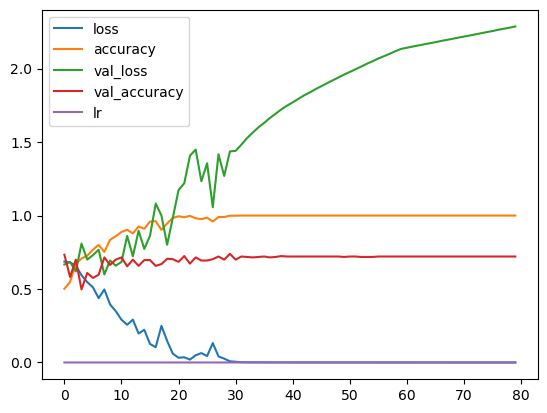

In [12]:
losses = pd.DataFrame(history.history)
losses.plot()

In [13]:
y_pred = model.predict(x_test)
y_pred_binary = (y_pred > 0.5).astype(int)
print(classification_report(y_test,y_pred_binary))


11/11 [==============================] - 0s 16ms/step
              precision    recall  f1-score   support

           0       0.79      0.88      0.83       242
           1       0.52      0.35      0.42        88

   micro avg       0.74      0.74      0.74       330
   macro avg       0.65      0.62      0.63       330
weighted avg       0.72      0.74      0.72       330
 samples avg       0.74      0.74      0.74       330

